# Savor Data

> Taking advantage of my own big data.

A data-driven project by [Tobias Reaper](https://github.com/tobias-fyi/)

## Part 3: EDA and Visualization

* Connect to the Savor data in local Postgres instance
    * Until db is set up, load from CSV
* Initial exploration and visualization

---
---

## Intro

> Take advantage of your own big data.

Savor is a project based on an idea that I first had in 2016. At the time I was working as a consultant for an enterprise resource planning (ERP) software company. I worked intimately with manufacturers to integrate our system into their business, with the goal of optimizing their manufacturing processes. I became fascinated by the idea of tracking things to such a degree, and began to imagine what it would be like to have a similar type of system that would optimize my life.

That's the core idea: building a system to organize my life as if it were a series of manufacturing processes.

That way of saying it may initially make it seem impersonal. I believe it's the opposite, in fact. The goal is to use software to understand myself better. That's where the tagline comes from — I'd like to take advantage of my own big data to make my life better in whatever ways I see fit at any given time.

Companies like Google and Facebook have been taking advantage of my big data for years, with the primary goal of making money. In the process of segmenting and profiling me, they likely know a lot about me. I'd like to have a similar data-driven profile of my life, for my own purposes. Namely, to learn more about myself and my life, to be able to optimize it.

I guess it's at this point that I can see people rolling their eyes and thinking this is just another productivity app. Words like "optimize" don't help things. However, I want to get across the fact that because I have total control over this system, that I get to choose exactly how it gets used and precisely what is optimized. While sometimes this optimization would come in the form of making myself more productive, it's equally likely that I'll want to optimize the length of time and quality of connection I have with family and friends.

Imagine that: a system that can help you find time to spend with family and friends, and find mindsets and/or conversation topics that will most likely increase the quality of those connections.

I think that sounds like the opposite of impersonal — getting intimate with oneself on levels and to a degree potentially not possible before.

...

### Data Model

The latest data model I came up with for my journal is one that has 3 distinct layers (with more to come in proceeding iterations).

1. Project Log
2. Engagement Log
3. Moment Log

The naming was not completely arbitrary, though could definitely be improved — the names aren't perfectly self-explanatory.

Basically, the reason I broke it up has to do with something I noticed about how my time is spent. At the top level, I try to work on a single "project" for a certain period of time. This helps me stay focused on what I wanted to do/work on during that time. Another way to think about it is that this level defines overarching parts of the day, usually somewhere between 5 and 10, depending on what I'm doing.

Within each block of time (maybe that's a better name right there — "block") I can switch between specific activities, such as between coding, writing, and reading/research. That is the second level, with each individual activity assigned to that higher level block. This second level is where the vast majority of the action is; the level where I spend most of my time.

The third level is for very short activities I do that aren't necessarily related to the main activity. For example, I could be working on the notebook to explore this data but take short little breaks to get water, use the restroom, or clear my head. In the previous iteration of the data model I didn't account for these little activities — every activity was "created equal", so to speak, and in order to account for that time, I'd have to split up and duplicate the main activity record, interspersing the short breaks into them that way. Simply put, that caused too much overhead sometimes.

The goal with this project is to reduce the time and effort required to keep a real-time journal to the point where it doesn't interrupt what I'm actually doing.

### Notebook in context

I wanted to explain about the project and how the data is set up to give some context. The last bit of context for now is how this notebook fits into the project.

> This notebook will focus primarily on exploring the `engage_log` table. The primary features I'll be exploring in this notebook are:

* `time_in`
* `time_out`
* `duration`
* `mental`
* `physical`
* `mental_note`
* `physical_note`
* `subloc`
* `project_location`

There are many others that I could and will use, but I'll save those for another notebook.

I am starting with this table because it is the experiential layer in which most of my experience is documented. The other layers are mostly there to support the `engage_log`, whether to provide a sort of group index (`project_log`) or to append additional information (`moment_log`).

Let's get into it!

### Imports and Config

In [39]:
# === Some initial imports and config === #
from os import environ
from pprint import pprint

import pandas as pd
import numpy as np
import janitor
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas config
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Accessing the data

#### TODO: Load from Savor database

Once the [previous notebook](02-savor_data_pipelines.ipynb) is done, the pipeline between Airtable and my local Postgres instance will make it easy to keep my local Postgres up to date. Once that is the case, I'll load the data directly from there.

#### Load data from CSV

Until then, however, I'm going to use CSVs which I downloaded from Airtable via their browser GUI.

In [2]:
# Load data from csv
data_path = "../../assets/data_/20-09-07-engage_log.csv"
engage_1 = pd.read_csv(data_path)

---
---

## Initial Wrangling

* Pruning the dataset right away to only the columns I'm using in this analysis
* Removing the single null value at the very end of the dataset (the record that hasn't ended yet)
    * The rest are filled with empty strings
* Fixing data types
    * Datetimes
    * `duration`

### Pruning

In [3]:
# Clean up columns to only what's needed right now
print("Initial shape:", engage_1.shape)

engage_keep_cols = [
    "time_in",
    "time_out",
    "duration",
    "mental",
    "physical",
    "mental_note",
    "physical_note",
    "subloc",
    "project_location",
]

# Copy columns into new dataframe
engage_2 = engage_1[engage_keep_cols].copy()
print("After column pruning:", engage_2.shape)
engage_2.head(3)

Initial shape: (12297, 23)
After column pruning: (12297, 9)


,time_in,time_out,duration,mental,physical,mental_note,physical_note,subloc,project_location
0,2019-12-03 06:00,2019-12-03 06:19,19:00,Podcast,Exercise,Full Stack Radio - Evan Yue \\ Vue 3.0 + new e...,Cardio - elliptical,Elliptical,24hr-Bel
1,2019-12-03 06:19,2019-12-03 06:37,18:00,Podcast,Exercise,Full Stack Radio with Evan Yue \\ Vue 3.0 - fi...,Cardio - stairs,Stairmaster,24hr-Bel
2,2019-12-03 06:37,2019-12-03 07:02,25:00,Podcast,Exercise,Django Chat \\ Caching - something to read up ...,Weights - hip abduction in / out (machine) - k...,Machines,24hr-Bel


### Nulls

In [4]:
# The null in time_out and duration is the current record - can be removed
engage_3 = engage_2.dropna(axis=0, subset=["time_out"])
# Fill remaining nulls with empty string
engage_3 = engage_3.fillna(value="")
# Confirm it worked
engage_3.isnull().sum()

time_in             0
time_out            0
duration            0
mental              0
physical            0
mental_note         0
physical_note       0
subloc              0
project_location    0
dtype: int64

In [5]:
# Fix datetime columns
from savor_code.pipelines import convert_datetime_cols

date_cols = [
    "time_in",
    "time_out",
]

engage_4 = convert_datetime_cols(engage_3, date_cols)
    
engage_4.dtypes

time_in             datetime64[ns]
time_out            datetime64[ns]
duration                    object
mental                      object
physical                    object
mental_note                 object
physical_note               object
subloc                      object
project_location            object
dtype: object

### Convert duration to minutes

The `duration` feature was imported as a string, which makes sense given the format: `[hh:]mm:ss`. To convert this into minutes, I'll split on the colon and extract the hours and minutes, multiplying the hours by 60 and adding them to the minutes. I can leave out the seconds, as I did not capture the timestamps at that level of detail.

Unfortunately, if the hour is not present in the record, it simply doesn't include that segment. Therefore, I had to write a custom function to both split and calculate the minutes.

In [6]:
def split_and_calculate_mins(cell: str) -> int:
    """Splits up `duration` based on colon, accounting for missing hours.
    Expects format: [hh:]mm:ss."""
    # Split up cell into component parts
    segments = [int(s) for s in cell.split(":")]
    # Check length - if more than 2, means hour is present
    if len(segments) > 2:
        # Calculate mins from hours and sum
        return (segments[0] * 60) + segments[1]
    elif len(segments) == 2:  # Case with mins:secs
        # Simply return the minutes
        return segments[0]
    else:  # Catch edge case when no duration
        return 0

In [9]:
# Use apply to convert duration to integer
engage_4["duration"] = engage_4["duration"].apply(split_and_calculate_mins)
engage_4.head()

,time_in,time_out,duration,mental,physical,mental_note,physical_note,subloc,project_location
0,2019-12-03 06:00:00,2019-12-03 06:19:00,19,Podcast,Exercise,Full Stack Radio - Evan Yue \\ Vue 3.0 + new e...,Cardio - elliptical,Elliptical,24hr-Bel
1,2019-12-03 06:19:00,2019-12-03 06:37:00,18,Podcast,Exercise,Full Stack Radio with Evan Yue \\ Vue 3.0 - fi...,Cardio - stairs,Stairmaster,24hr-Bel
2,2019-12-03 06:37:00,2019-12-03 07:02:00,25,Podcast,Exercise,Django Chat \\ Caching - something to read up ...,Weights - hip abduction in / out (machine) - k...,Machines,24hr-Bel
3,2019-12-03 07:02:00,2019-12-03 07:08:00,6,Podcast,Walk,Not so standard deviations \\ misc discussions...,Walked to locker room then to car,Outside,24hr-Bel
4,2019-12-03 07:08:00,2019-12-03 07:20:00,12,Podcast,Drive,SE Daily \\ TIBCO,,Trinity,24hr-Bel


In [10]:
engage_4.dtypes

time_in             datetime64[ns]
time_out            datetime64[ns]
duration                     int64
mental                      object
physical                    object
mental_note                 object
physical_note               object
subloc                      object
project_location            object
dtype: object

In [23]:
# Save modified dataset back to CSV, for posterity
# engage_4.to_csv("../assets/data_/20-09-07-engage_log_clean.csv", index=False)

---
---

## Exploration and Visualization

There are so, so many interesting questions to ask and avenues to explore with this data, it was almost overwhelming at first. I'd been brainstorming casually over the years on the topic of how to tackle the exploratory analysis and visualization.

Here are a few ideas to get me started:

* How do I spend my time?
    * Total sums / averages over the entire dataset - compare:
        * Total length of time for each activity
        * Average length of time for each activity
    * What patterns does this follow on a daily, weekly, monthly, yearly time horizon?
* How much do I write about my experience?
    * Word counts: total, total/avg per month over time
* Sentiment analysis over time
  * Does my mood oscillate according to any discernable pattern?
  * Does my mood correlate with spending time on particular activities?

### How do I spend my time?

In [11]:
# Make copy of dataframe to explore mental/physical activities
act_1 = engage_3[["time_in", "time_out", "duration", "mental", "physical"]].copy()
act_1.head()

,time_in,time_out,duration,mental,physical
0,2019-12-03 06:00,2019-12-03 06:19,19,Podcast,Exercise
1,2019-12-03 06:19,2019-12-03 06:37,18,Podcast,Exercise
2,2019-12-03 06:37,2019-12-03 07:02,25,Podcast,Exercise
3,2019-12-03 07:02,2019-12-03 07:08,6,Podcast,Walk
4,2019-12-03 07:08,2019-12-03 07:20,12,Podcast,Drive


In [70]:
# Get lists (sets) of all activities
mental_set = {act for acts in act_1["mental"] for act in acts.split(",")}
physical_set = {act for acts in act_1["mental"] for act in acts.split(",")}

# How many distinct activities?
print(len(mental_list))
print(len(physical_list))

51
65


#### Total time spent on activities

Given how many activities there are, most of the visualizations I'll be creating will only include up to ~15.

In [45]:
# Get total sum of activities
from collections import Counter

# Counters for total time and total number of occurrences
mental_sums = Counter()
physical_sums = Counter()
mental_count = Counter()
physical_count = Counter()

# Iterate through all rows + lists within rows
for row in act_1.itertuples(index=False):
    # Split on comma, add time to each item
    for w in row[3].split(","):
        mental_count[w] += 1
        mental_sums[w] += row[2]
    for f in row[4].split(","):
        physical_count[f] += + 1
        physical_sums[f] += row[2]

In [19]:
# Look at top 10 activities by total time spent
print("Mental:")
for mental in mental_sums.most_common(10):
    print(f"  {mental}")
print("\nPhysical:")
for physical in physical_sums.most_common(10):
    print(f"  {physical}")

Mental:
  ('Sleep', 129453)
  ('Converse', 72596)
  ('Code', 49092)
  ('Watch', 28160)
  ('Podcast', 21496)
  ('Audiobook', 21309)
  ('Information', 21146)
  ('Learn', 19914)
  ('Think', 19283)
  ('Write', 15077)

Physical:
  ('Rest', 152607)
  ('Sit', 86098)
  ('Stand', 70127)
  ('Drive', 13296)
  ('Eat', 11113)
  ('Cook', 8448)
  ('Dress', 7028)
  ('Dishes', 6124)
  ('Exercise', 6086)
  ('Dental hygiene', 5998)


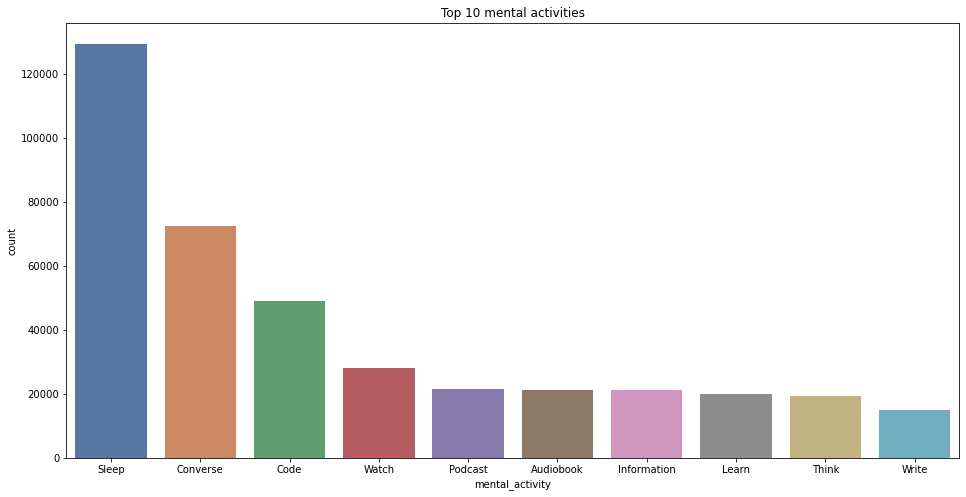

In [43]:
# Cast counter to dataframe and visualize
mental_bar_1 = (pd.DataFrame.from_dict(dict(mental_sums.most_common(10)), orient="index", columns=["count"])
                .reset_index()
                .rename_column("index", "mental_activity")
                )
# Visualize the top mental activities
plt.figure(figsize=(16, 8))
sns.barplot("mental_activity", "count", data=mental_bar_1, palette="deep");
plt.title("Top 10 mental activities");

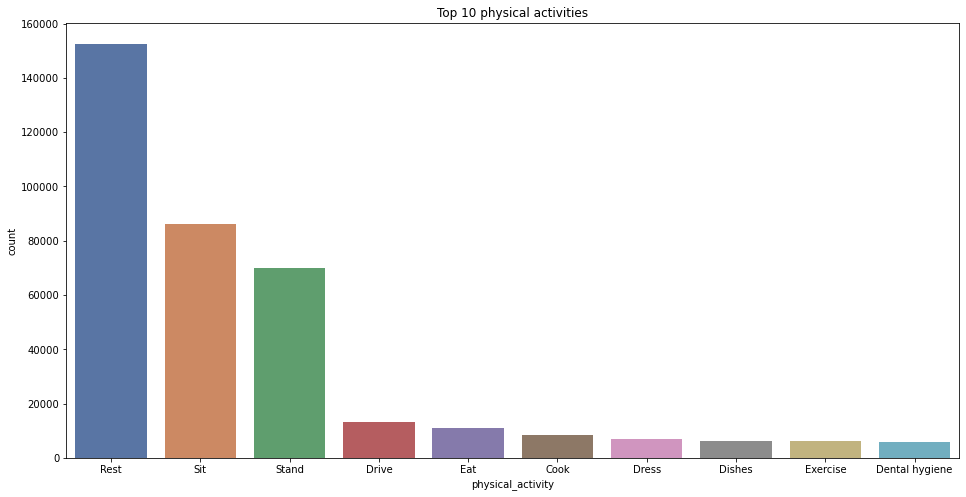

In [42]:
# Cast counter to dataframe and visualize
physical_bar_1 = (pd.DataFrame.from_dict(dict(physical_sums.most_common(10)), orient="index", columns=["count"])
                .reset_index()
                .rename_column("index", "physical_activity")
                )
# Visualize the top physical activities
plt.figure(figsize=(16, 8))
sns.barplot("physical_activity", "count", data=physical_bar_1, palette="deep");
plt.title("Top 10 physical activities");

#### Average time spent on activities

In [46]:
# Look at top 10 activities by number of records
print("Mental:")
for mental in mental_count.most_common(10):
    print(f"  {mental}")
print("\nPhysical:")
for physical in physical_count.most_common(10):
    print(f"  {physical}")

Mental:
  ('Converse', 2821)
  ('Think', 2070)
  ('Podcast', 1089)
  ('Update journal', 1006)
  ('Audiobook', 932)
  ('Watch', 692)
  ('Information', 631)
  ('Code', 602)
  ('Workflow', 508)
  ('Space out', 505)

Physical:
  ('Sit', 2232)
  ('Stand', 2191)
  ('Rest', 1116)
  ('Water', 792)
  ('Dress', 769)
  ('Eat', 569)
  ('Cap', 521)
  ('Dishes', 490)
  ('Skin/face', 428)
  ('Setup', 350)


In [59]:
# Dict of total time divided by number of occurrences
mental_avg_dict = {}

for act in mental_count:
    mental_avg_dict[act] = mental_sums[act] / mental_count[act]

# Remove some items that shouldn't be there
mental_avg_dict.pop("Break")
mental_avg_dict.pop("Fantasy")

# Cast to dataframe, sort descending
mental_avg_df = pd.DataFrame.from_dict(mental_avg_dict, orient="index", columns=["avg_mins"]).reset_index()
mental_avg_df = mental_avg_df.sort_values("avg_mins", ascending=False)
mental_avg_df.head(10)

,index,avg_mins
18,Sleep,428.652318
34,Socialize,121.857143
48,Mix,104.333333
41,Sojourn,90.333333
35,Game,87.500000
26,Architect—space,83.333333
10,Code,81.548173
45,Play,81.000000
4,Data acquisition,74.737705
5,Learn,73.483395


In [66]:
# Dict of total time divided by number of occurrences
physical_avg_dict = {}

for act in physical_count:
    physical_avg_dict[act] = physical_sums[act] / physical_count[act]

# Remove some items that shouldn't be in there
physical_avg_dict.pop("Break")
physical_avg_dict.pop("")

# Cast to dataframe, sort descending
physical_avg_df = pd.DataFrame.from_dict(physical_avg_dict, orient="index", columns=["avg_mins"]).reset_index()
physical_avg_df = physical_avg_df.sort_values("avg_mins", ascending=False)
physical_avg_df.head(10)

,index,avg_mins
43,Snowboard,195.428571
13,Rest,136.744624
52,Play,99.846154
61,Paddle,98.000000
59,SUP,81.500000
40,Surf,66.500000
58,Sail,65.000000
56,Hike,65.000000
39,Craft,56.666667
48,Dance,53.000000


This is not as interesting as the total time, as this naive way of calculating averages does not take into account when the same activity is assigned to multiple records in a row. Therefore, all this is showing is what activities I leave as a single record.

It would be an interesting problem to solve, giving me some good algorithmic problem solving practice, but not really in the scope of this notebook.

In [44]:
act_1.head()

,time_in,time_out,duration,mental,physical
0,2019-12-03 06:00,2019-12-03 06:19,19,Podcast,Exercise
1,2019-12-03 06:19,2019-12-03 06:37,18,Podcast,Exercise
2,2019-12-03 06:37,2019-12-03 07:02,25,Podcast,Exercise
3,2019-12-03 07:02,2019-12-03 07:08,6,Podcast,Walk
4,2019-12-03 07:08,2019-12-03 07:20,12,Podcast,Drive


Iterate through grouped-by-month data with same idea as far as counter?

#### Split up mental and physical

Some records contain multiple mental and physical activities, which will need to be split up.

In [36]:
# Split up mental
mental_df = act_1["mental"].str.split(",", expand=True)
# Rename columns
for i, col in enumerate(mental_df.columns):
    mental_df = mental_df.rename(columns={i: f"mental_{i}"})
# Concatenate back into main frame; drop original feature
act_2 = pd.concat([act_1, mental_df], axis=1).drop(columns=["mental"])
act_2.head()

# Split up physical
physical_df = act_1["physical"].str.split(",", expand=True)
# Rename columns
for i, col in enumerate(physical_df.columns):
    physical_df = physical_df.rename(columns={i: f"physical_{i}"})
# Concatenate back into main frame; drop original feature
act_3 = pd.concat([act_2, physical_df], axis=1).drop(columns=["physical"])
act_3.head()

,time_in,time_out,duration,mental_0,mental_1,mental_2,mental_3,physical_0,physical_1,physical_2
0,2019-12-03 06:00:00,2019-12-03 06:19:00,19,Podcast,None,None,None,Exercise,None,None
1,2019-12-03 06:19:00,2019-12-03 06:37:00,18,Podcast,None,None,None,Exercise,None,None
2,2019-12-03 06:37:00,2019-12-03 07:02:00,25,Podcast,None,None,None,Exercise,None,None
3,2019-12-03 07:02:00,2019-12-03 07:08:00,6,Podcast,None,None,None,Walk,None,None
4,2019-12-03 07:08:00,2019-12-03 07:20:00,12,Podcast,None,None,None,Drive,None,None


In [38]:
# Requires datetime index
act_3["time_in"].groupby(pd.Grouper(freq="M"))

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'